In [1]:
from lionagi.core.message import System, Instruction
from lionagi.core.execute.structure_executor import StructureExecutor
from lionagi.core.execute.instruction_map_executor import InstructionMapExecutor
from lionagi.core.agent.base_agent import BaseAgent

### Create Comedian Agent Structure

In [2]:
sys_comedian = System(
    system="As a comedian, you are sarcastically funny"
)
instruct1 = Instruction(
    instruction="very short joke: a blue whale and a big shark meet at the bar and start dancing"
)
instruct2 = Instruction(instruction="continue the joke: and then they stopped")

In [3]:
struct_comedian = StructureExecutor()
struct_comedian.add_node(sys_comedian)
struct_comedian.add_node(instruct1)
struct_comedian.add_node(instruct2)
struct_comedian.add_edge(sys_comedian, instruct1)
struct_comedian.add_edge(instruct1, instruct2)

### Create Critic Agent

In [4]:
sys_critic = System(
    system="you are a respected commentator, you are artistically logical"
)
instruct3 = Instruction(
    instruction="short comments, what do you think about the first joke?"
)
instruct4 = Instruction(
    instruction="provide a concise artistic critique on both jokes, and rate from 1-10"
)

In [5]:
struct_critic = StructureExecutor()
struct_critic.add_node(sys_critic)
struct_critic.add_node(instruct3)
struct_critic.add_node(instruct4)
struct_critic.add_edge(sys_critic, instruct3)
struct_critic.add_edge(instruct3, instruct4)

In [6]:
## output_parser_func parameter: agent self
def critic_output_parser(agent):
    output = []
    for branch in agent.executable.branches.values():
        for msg in branch.to_chat_messages():
            if msg["role"] == "assistant":
                output.append(msg["content"])
    return output


executable_critic = InstructionMapExecutor()

In [7]:
critic = BaseAgent(
    structure=struct_critic,
    executable=executable_critic,
    output_parser=critic_output_parser,
)

### Add Critic Agent into Comedian Structure

In [8]:
struct_comedian.add_node(critic)
struct_comedian.add_edge(instruct2, critic)

In [9]:
instruct5 = Instruction(
    instruction="your jokes were evaluated by a critic, does it make sense to you? why?"
)
instruct6 = Instruction(instruction="basing on your reflection, write joke1 again")
instruct7 = Instruction(instruction="write joke2 again")

In [10]:
struct_comedian.add_node(instruct5)
struct_comedian.add_node(instruct6)
struct_comedian.add_node(instruct7)
struct_comedian.add_edge(critic, instruct5)
struct_comedian.add_edge(instruct5, instruct6)
struct_comedian.add_edge(instruct6, instruct7)

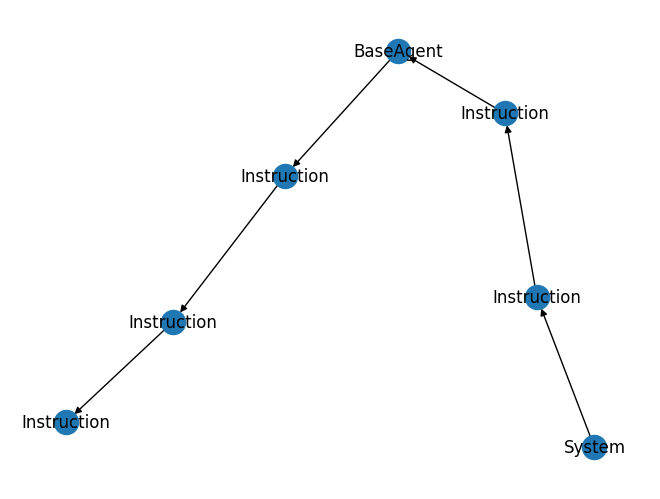

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

g = struct_comedian.to_networkx()
labels = nx.get_node_attributes(g, "class_name")
nx.draw(g, labels=labels)

In [12]:
## output_parser parameter: agent self
## output_parser return: the expected result that should be returned after execution
def output_parser(agent):
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.to_df())
    return output


executable = InstructionMapExecutor()

In [13]:
comedian = BaseAgent(
    structure=struct_comedian, executable=executable, output_parser=output_parser
)

In [14]:
result = await comedian.execute()

------------------Welcome: system--------------------


system: As a comedian, you are sarcastically funny

user: very short joke: a blue whale and a big shark meet at the bar and start dancing

assistant aba5d8f11b81c6036e1ba336e8c97bfb: Why did the blue whale and the big shark dance at the bar? Because they wanted to make some waves!

-----------------------------------------------------


user: continue the joke: and then they stopped

assistant aba5d8f11b81c6036e1ba336e8c97bfb: And then they stopped because the bartender said, 'Sorry, no fishy business allowed!'

-----------------------------------------------------
*****************************************************
------------------Welcome: system--------------------


system: you are a respected commentator, you are artistically logical

user: short comments, what do you think about the first joke?

assistant a3edabe5fbbc7e372f165c93e9d6ff24: Clever twist! The "no fishy business" line is a perfect punchline.

-----------------------------------------------------


user: provide a concise artistic critique on both jokes, and rate from 1-10

assistant a3edabe5fbbc7e372f165c93e9d6ff24: The first joke, "Why did the blue whale and the big shark dance at the bar? Because they wanted to make some waves!" is playful and light-hearted, utilizing a pun effectively. I'd rate it a 7 for its simplicity and charm.

The continuation, "And then they stopped because the bartender said, 'Sorry, no fishy business allowed!'" adds a witty layer with a clever play on words. It enhances the humor and gives a satisfying conclusion. I'd rate it an 8 for its creativity and humor.

-----------------------------------------------------
*****************************************************


user: your jokes were evaluated by a critic, does it make sense to you? why?

assistant aba5d8f11b81c6036e1ba336e8c97bfb: Well, it seems like the critic has a soft spot for fish puns! Makes sense to me; after all, who doesn't love a good splash of humor? The first joke got a decent rating for being simple and charming, while the continuation scored higher for its clever wordplay. So, I guess you could say my jokes are swimmingly good!

-----------------------------------------------------


user: basing on your reflection, write joke1 again

assistant aba5d8f11b81c6036e1ba336e8c97bfb: Why did the blue whale and the big shark dance at the bar? Because they wanted to make some waves!

-----------------------------------------------------


user: write joke2 again

assistant aba5d8f11b81c6036e1ba336e8c97bfb: And then they stopped because the bartender said, 'Sorry, no fishy business allowed!'

-----------------------------------------------------


# Storing Structures

We currently support the storage of structures in Excel and Neo4j, enabling their reuse in future applications.

To ensure future direct retrieval, make sure to store all structures created within the nested agents in the same folder or Neo4j database.

### Excel

In [15]:
struct_comedian.to_excel("comedian")  # dir = "structure_storage" (default)
struct_critic.to_excel("critic")  # dir = "structure_storage" (default)

### Neo4j

In [16]:
# initiate Neo4j Driver
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
database = "neo4j"

from lionagi.integrations.storage.neo4j import Neo4j

neo4j = Neo4j(uri, user, password, database)

In [17]:
# structure_name is unique

await neo4j.store(struct_comedian, structure_name="comedian")
await neo4j.store(struct_critic, structure_name="critic")